**DEEP LEARNING TECHNOLOGIES CW3**

In this notebook 4 different architectures are implemented for the dataset. The implemented architectures are
1. Convolutional Neural Network
2. Recurrent Neural Network - LSTM
3. Artificial Neural Network
4. Gated Recurrent Unit 

In [ ]:
# Library Importation
import os
import pandas as pd # performs array operation
import random # generates random generators
import numpy as np # performs array operation
import librosa #to visualize the audio features (audio and music analysis)
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns #to visualize/ plot the figures
import matplotlib.pyplot as plt #to visualize/ plot the figures
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split #to split the data as train and test
from tensorflow import keras #library used to build the architectures
from tensorflow.keras.layers import (Conv1D, BatchNormalization, Dropout, Flatten, Dense, MaxPool1D)
from tensorflow.keras import initializers

**Pre-Process Step**

In [ ]:
# creating an  empty array to store path,co-efficients (MFCC) and labels.
audio_path, emo_labels, audio_duration = [], [], [] 

# loop (initiated by for) through all the sub-folders in the audio file
#dirmanes - all the names in subfolder, filenames - all the file names 
for dirname, _, filenames in os.walk('../input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        
        audio_path.append(os.path.join(dirname, filename))
        
        audio_duration.append(round(librosa.get_duration(filename=audio_path[-1]), 3))
        #split based on '_' and extractsonly the last index(-1)
        label = filename[::-1].split('_')[0][::-1]
        emo_labels.append(label[:-4].lower())

#creates data frame
df = pd.DataFrame({'path':audio_path,'duration': audio_duration, 'dataset': 'T.O_EMO', 'emotion':emo_labels})
#replace the abbreviated emotion ps to full form as surprise
df['emotion'] = df['emotion'].replace(['ps'], 'surprise')

In [ ]:
#generates a sample columns and rows
df.sample(7)

,path,duration,dataset,emotion
4883,../input/toronto-emotional-speech-set-tess/tes...,1.756,T.O_EMO,happy
5336,../input/toronto-emotional-speech-set-tess/tes...,2.442,T.O_EMO,sad
4092,../input/toronto-emotional-speech-set-tess/tes...,2.572,T.O_EMO,sad
898,../input/toronto-emotional-speech-set-tess/TES...,1.943,T.O_EMO,neutral
1629,../input/toronto-emotional-speech-set-tess/TES...,2.179,T.O_EMO,neutral
121,../input/toronto-emotional-speech-set-tess/TES...,1.789,T.O_EMO,fear
3728,../input/toronto-emotional-speech-set-tess/tes...,2.143,T.O_EMO,neutral


In [ ]:
df.info()
#Exploratory data analysis for the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      5600 non-null   object 
 1   duration  5600 non-null   float64
 2   dataset   5600 non-null   object 
 3   emotion   5600 non-null   object 
dtypes: float64(1), object(3)
memory usage: 175.1+ KB


In [ ]:
# extracting the co-efficients (MFCC) for each audio file
def mfcc_extraction(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5) # load each file path(audio)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0) #n_mfcc - number of co-eff to be extracted
    return mfcc #returns

In [ ]:
#applies the mfccs to each audio path
X_mfcc = df['path'].apply(lambda X: mfcc_extraction(X))
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
5595    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
5596    [-313.96478, 39.847843, -5.6493053, -3.867575,...
5597    [-357.54886, 77.886055, -15.224756, 2.194633, ...
5598    [-353.1474, 101.68391, -14.175896, -12.037376,...
5599    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: path, Length: 5600, dtype: object

In [ ]:
X =[x for x in X_mfcc]
X = np.array(X) #changes into array
X.shape #checks the shape of the array
#5600 - rows, 40 - columns

(5600, 40)

In [ ]:
X=np.expand_dims(X,-1) #expanding the shape of the array
X.shape #checks the shape

(5600, 40, 1)

In [ ]:
#selecting the target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values #calculting the value of each emotion

# implementing the features
X = X_mfcc.copy()

# the dataset is split into train, validation & test sets
# creating the train/test splits
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)
# creating the train/validation splits
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, shuffle=True, random_state=0)

# Converting the created train/val/test sets into arrays using numpy
x_train = np.array([i for i in x_train])
x_validation = np.array([i for i in x_validation])
x_test = np.array([i for i in x_test])

# prints the shape of tarin, validation and test set (rows,columns)
print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)

(3528, 40)
(1512, 40)
(560, 40)


In [ ]:
#Scaling the data to build the architecture
# from the training set the mean and standard deviation is computed
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)

# performs data scaling
x_train = (x_train - train_mean)/train_std
x_validation = (x_validation - train_mean)/train_std
x_test = (x_test - train_mean)/train_std

In [ ]:
#to build the architecture changing the shape by adding an dimension to the mfccs (co-efficients)
print(f"The dimension of x_train before any change - {x_train.shape}") #checks the shape  before the change

x_train = x_train[..., None]
x_validation = x_validation[..., None]
x_test = x_test[..., None]

print(f"The dimension of x_train before any change - {x_train.shape}")  #checks the shape after the change

The dimension of x_train before any change - (3528, 40)
The dimension of x_train before any change - (3528, 40, 1)


**Convolution Neural Network**

In [ ]:
#creating a CNN model
#param - input_shape(tuple): size/shape of the input set
#returns model: CNN model

# building the topology/model in sequentail
model = keras.Sequential()  
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(40,1))) #1st CNN Layer with activation fn 'relu'
model.add(MaxPool1D(pool_size=2)) #cal the maximum value and downsamples
model.add(BatchNormalization()) #uses higher learning rate
model.add(Conv1D(filters=64, kernel_size=3, activation="relu")) #2nd CNN Layer with activation fn 'relu'
model.add(MaxPool1D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten()) #converts the 2D arrays into single continuous linear vector
model.add(Dropout(0.2))  #dropout layer to avoid overfitting - sets the dropout to 20%
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))  #dense layer acts as the input to the output layer
model.add(Dropout(0.2)) 
model.add(Dense(units=7, activation="softmax")) # output layer with the 'softmax' classifier
# 7 neurons belongs to the 7 different emotions that has to be predicted

model.summary() 
#prints the summary of the model with the number of layers, its dimensions and parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                        

In [ ]:
# model compilation with the default learning rate
#Adam as the optimizer
#tracks accuracy
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# train the model
#fits the model
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=100,#set the epoch to any number to train the model
    batch_size=32,
    validation_data=(x_validation, y_validation),
)

Epoch 1/100
111/111 [==============================] - 3s 11ms/step - loss: 0.3538 - accuracy: 0.8778 - val_loss: 0.6611 - val_accuracy: 0.9048
Epoch 2/100
111/111 [==============================] - 1s 9ms/step - loss: 0.0620 - accuracy: 0.9827 - val_loss: 0.2247 - val_accuracy: 0.9306
Epoch 3/100
111/111 [==============================] - 1s 8ms/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.0416 - val_accuracy: 0.9841
Epoch 4/100
111/111 [==============================] - 1s 9ms/step - loss: 0.0327 - accuracy: 0.9906 - val_loss: 0.0095 - val_accuracy: 0.9974
Epoch 5/100
111/111 [==============================] - 1s 8ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/100
111/111 [==============================] - 1s 9ms/step - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/100
111/111 [==============================] - 1s 9ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0030 - val_accuracy: 1.000

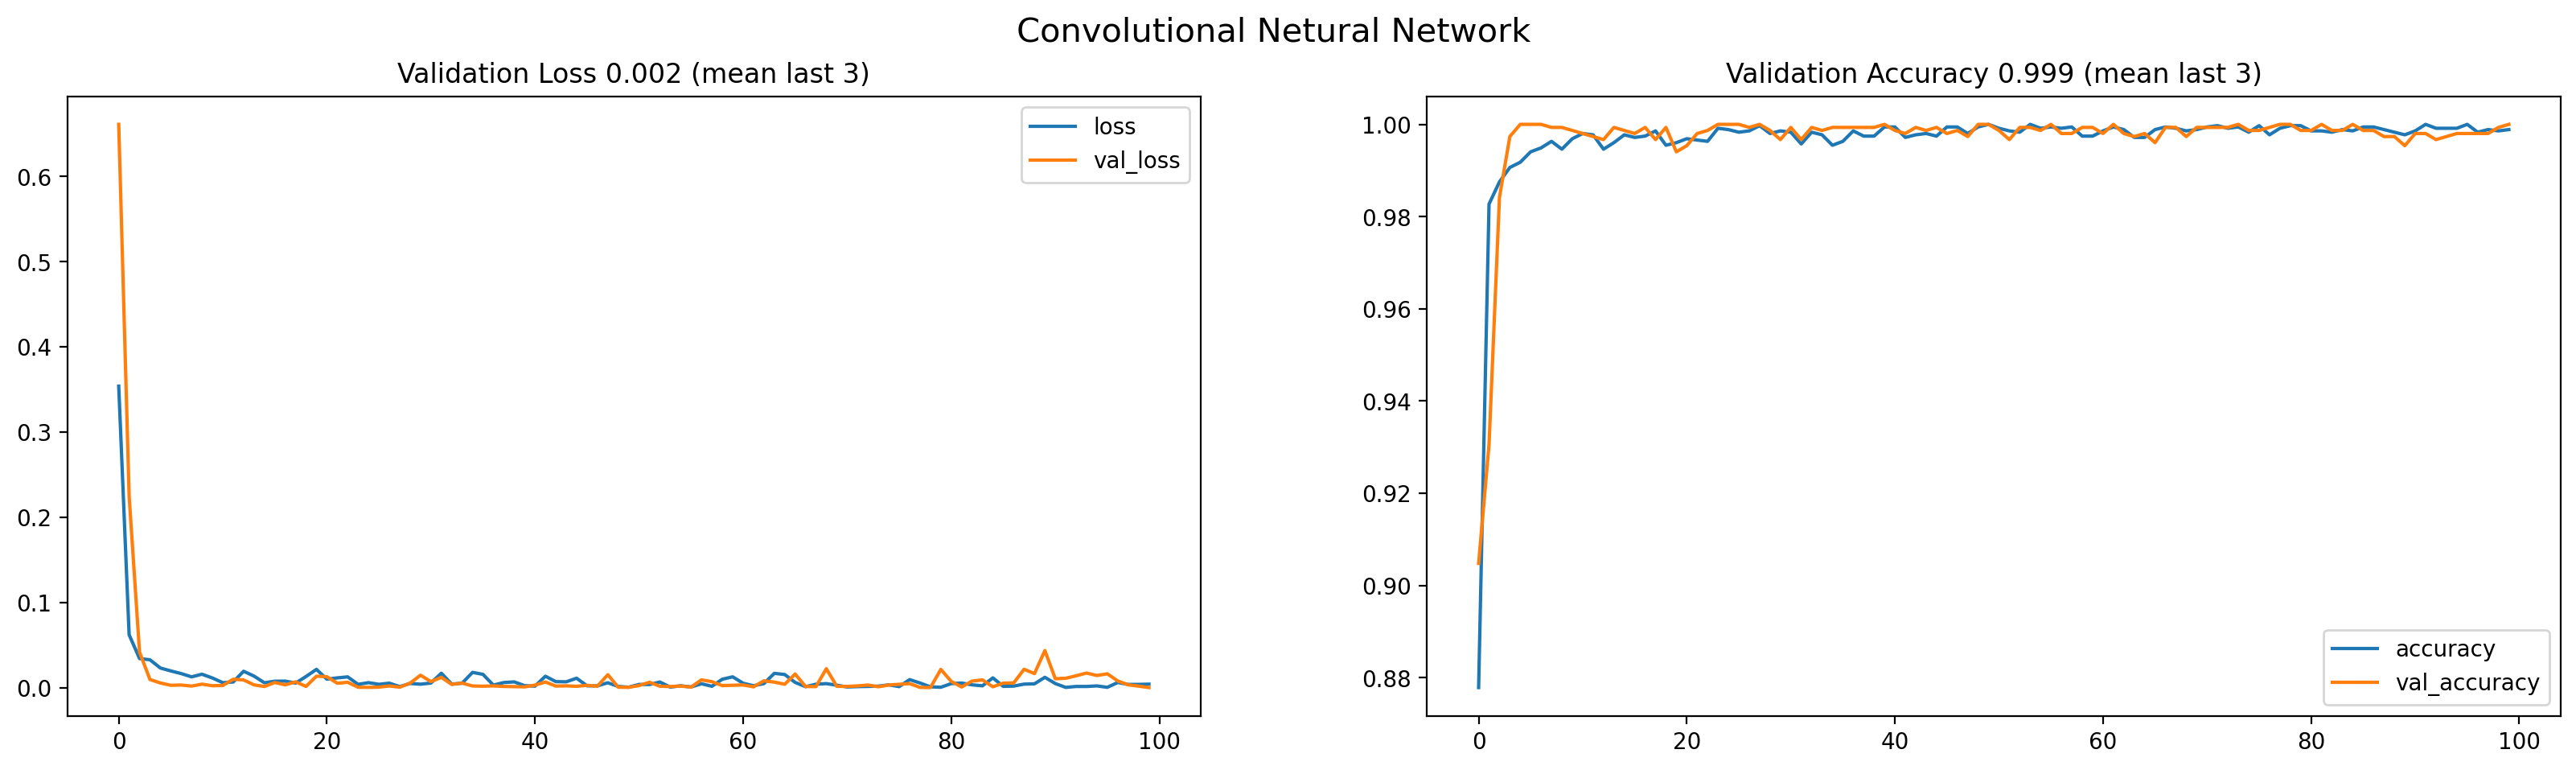

In [ ]:
# plot accuracy and error for training and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation Loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation Accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

In [ ]:
# evaluate loss and accuracy on the test set
loss_test, accuracy_test = model.evaluate(x_test, y_test)

print("Test Loss is {:.2f}".format(loss_test))
print("Test Accuracy is {:.2f}%".format(100 * accuracy_test))

18/18 [==============================] - 0s 3ms/step - loss: 6.8478e-05 - accuracy: 1.0000
Test Loss is 0.00
Test Accuracy is 100.00%


**RNN-LSTM Architecture**

In [ ]:
#importing neccesary packages
import torch
import librosa
import os
from torch.utils.data import Dataset, DataLoader, random_split
import os
import random
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
#inherits  PyTorch Dataset class
class AudioDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_names = []
        self.labels = []
        self.sample_rate = 22050
        self.duration = 30

        # Load file names and labels from the directory
        for i, genre in enumerate(os.listdir(data_dir)):
            genre_dir = os.path.join(data_dir, genre)
            for file_name in os.listdir(genre_dir):
                self.file_names.append(os.path.join(genre_dir, file_name))
                self.labels.append(i)

    def __getitem__(self, idx):
        # Load audio file and preprocess it
        audio_file, sr = librosa.load(self.file_names[idx], sr=self.sample_rate, duration=self.duration, res_type='kaiser_fast')
        audio_file = librosa.util.normalize(audio_file)

        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=audio_file, sr=sr, n_mfcc=13)

        # Convert features into a tensor
        features_tensor = torch.tensor(mfccs)

        # Convert label into a tensor
        label_tensor = torch.tensor(self.labels[idx])

        return features_tensor, label_tensor

    def __len__(self):
        return len(self.file_names)

def pad_sequence(batch):
    # Find the longest audio sample in the batch
    max_len = max([x[0].shape[1] for x in batch])

    # Pad all samples to the same length
    padded_batch = torch.zeros(len(batch), 13, max_len)
    for i, (sample, label) in enumerate(batch):
        padded_batch[i][:, :sample.shape[1]] = sample

    # Transpose the tensor to match PyTorch conventions
    padded_batch = padded_batch.transpose(1, 2)
    
    return padded_batch, torch.tensor([x[1] for x in batch])

# Create an instance of the AudioDataset class
audio_dataset = AudioDataset('D:/Southampton/course/SEM2/deep learning/cw3/extracted/TESS')

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(audio_dataset))
val_size = int(0.2 * len(audio_dataset))
test_size = len(audio_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(audio_dataset, [train_size, val_size, test_size])

# Create DataLoader instances for the datasets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=pad_sequence)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_sequence)


In [ ]:

#single layer LSTM layer
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes): #constructer of AudioLSTM taking input_size, hidden_size, num_layers, num_classes
        super(AudioLSTM, self).__init__()#calls constructor to initialize the module.
        self.hidden_size = hidden_size #initializes an instance variable
        self.num_layers = num_layers#initializes an instance variable
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #creating a new instance of the nn.LSTM class
        self.fc = nn.Linear(hidden_size, num_classes) #creating new instance of the nn.Linear class
#defining forward pass
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)# initializes the hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)#initializes the cell state
        out, _ = self.lstm(x, (h0, c0))# LSTM cell to the input tenso
        out = self.fc(out[:, -1, :])
        return out

In [ ]:

#setting device to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#instance of the AudioLSTM with required parameters 
model = AudioLSTM(input_size=13, hidden_size=64, num_layers=2, num_classes=10).to(device)
#instance of the cross-entropy loss function
criterion = nn.CrossEntropyLoss()
#instance of the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#setting num of epoch
num_epochs = 100
#printing training progress every 100 steps
print_every = 100
#total numof steps
total_step = len(train_dataloader)
#creating empty list to stores losses and accuracy of train ,validation
train_losses = []
train_accs = []
val_losses = []
val_accs = []
#start loops with epochs
for epoch in range(num_epochs):
    
    epoch_train_losses = []
    epoch_train_accs = []
    #training Mode
    model.train()
    #loop over the batches in the training dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        #move the input data and labels to the specified device
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)#passing input 
        loss = criterion(outputs, labels)#calculating loss

        optimizer.zero_grad() #he gradients of all optimized tensors
        loss.backward() # the gradients of the loss with respect to the model parameters.
        optimizer.step() #computing gradients and the specified optimizer

        # Compute training accuracy
        train_acc = torch.sum(torch.argmax(outputs, dim=1) == labels).item() / len(labels)
        epoch_train_accs.append(train_acc)
        epoch_train_losses.append(loss.item())
        
        # Print training progress
        if (i + 1) % print_every == 0:
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_acc))
    #appending training ,losses appending to array
    train_losses.append(np.mean(epoch_train_losses))
    train_accs.append(np.mean(epoch_train_accs))

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        epoch_val_accs = []
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute validation accuracy
            acc = torch.sum(torch.argmax(outputs, dim=1) == labels).item() / len(labels)
            epoch_val_accs.append(acc)
            epoch_val_losses.append(loss.item())

        val_acc = np.mean(epoch_val_accs)
        val_loss = np.mean(epoch_val_losses)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch + 1, num_epochs, train_losses[-1], train_accs[-1], val_loss, val_acc))



Epoch [1/100], Train Loss: 1.8478, Train Acc: 0.2632, Val Loss: 1.4325, Val Acc: 0.4149

Epoch [2/100], Train Loss: 1.2722, Train Acc: 0.4804, Val Loss: 1.1483, Val Acc: 0.4948

Epoch [3/100], Train Loss: 1.0671, Train Acc: 0.5789, Val Loss: 1.0431, Val Acc: 0.5816

Epoch [4/100], Train Loss: 0.8213, Train Acc: 0.6928, Val Loss: 0.6836, Val Acc: 0.7413

Epoch [5/100], Train Loss: 0.7222, Train Acc: 0.7130, Val Loss: 0.6228, Val Acc: 0.7986

Epoch [6/100], Train Loss: 0.5705, Train Acc: 0.7885, Val Loss: 0.6610, Val Acc: 0.7743

Epoch [7/100], Train Loss: 0.6019, Train Acc: 0.7656, Val Loss: 0.5884, Val Acc: 0.7378

Epoch [8/100], Train Loss: 0.5715, Train Acc: 0.7782, Val Loss: 0.6632, Val Acc: 0.7622

Epoch [9/100], Train Loss: 0.5228, Train Acc: 0.7877, Val Loss: 0.4574, Val Acc: 0.8212

Epoch [10/100], Train Loss: 0.4345, Train Acc: 0.8316, Val Loss: 0.3268, Val Acc: 0.9132

Epoch [11/100], Train Loss: 0.3944, Train Acc: 0.8576, Val Loss: 0.2459, Val Acc: 0.9323

Epoch [12/100], Tra

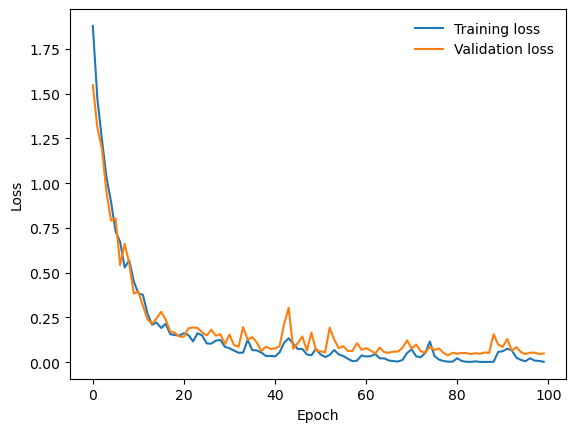

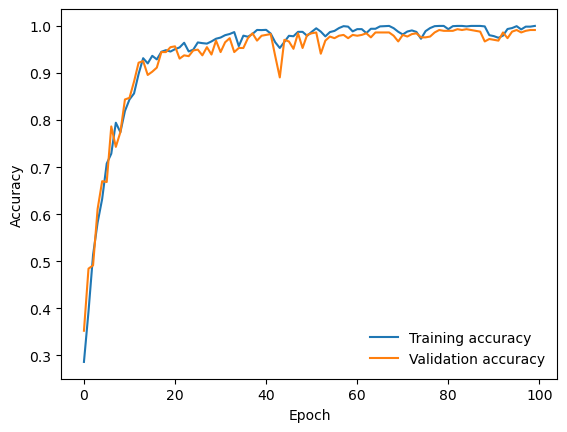

In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_acc = test_correct / len(test_dataloader.dataset)

print('Test Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.0012, Test Acc: 0.9893


In [ ]:
# Assuming you have loaded your test data and model already

# Set the model to evaluation mode
model.eval()

# Create lists to store the predicted and ground truth labels
predicted_labels = []
true_labels = []

# Iterate over the test data and make predictions
with torch.no_grad():
    for data, labels in test_dataloader:
        # Forward pass
        outputs = model(data)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Store the predicted and true labels
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Calculate the overall accuracy
correct = 0
total = 0
for i in range(len(true_labels)):
    if predicted_labels[i] == true_labels[i]:
        correct += 1
    total += 1
accuracy = correct / total
print(f"Overall accuracy: {accuracy:.3f}")

# Check individual predictions
for i in range(len(true_labels)):
    if predicted_labels[i] != true_labels[i]:
        print(f"Sample {i}: predicted {predicted_labels[i]}, actual {true_labels[i]}")


Overall accuracy: 0.989

Sample 121: predicted 1, actual 5

Sample 139: predicted 3, actual 2

Sample 159: predicted 5, actual 4


**ANN Architecture**

In [1]:
import zipfile
import os
import torch
from google.colab import drive
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
from IPython.display import Audio 
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from pydub import AudioSegment, effects
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Colab Notebooks')

with zipfile.ZipFile('TESS.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
mfcc=[]
extracted_features =[]
labels=[]

for dirname, _, filenames in os.walk('/content/data/TESS'):
    for filename in filenames:
        # Fetch the sample rate.
        _, sr = librosa.load(path = os.path.join(dirname,filename), sr = None) 
        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(dirname,filename)) 
        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom = 0)
        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

        f3 = librosa.feature.mfcc(y=normal_x, sr=sr, n_mfcc=128) # MFCC
        f3=np.mean(f3.T,axis=0)
        
        
        label = filename.split('_')[-1]
        label=label.split('.')[0]
        extracted_features.append([f3,label])

In [6]:
extracted_features = pd.DataFrame(extracted_features, columns=('features','op_labels'))
extracted_features.tail()

,features,op_labels
2795,"[789.2188, 43.247486, 22.96727, -6.4600844, -1...",fear
2796,"[779.7787, 44.28964, -26.690983, 14.31299, 0.5...",fear
2797,"[763.7055, 59.643227, 2.0130847, -8.501866, -1...",fear
2798,"[738.794, 55.098873, 11.643752, -14.8765135, 2...",fear
2799,"[796.23315, 31.176735, 7.731452, -3.0720294, -...",fear


In [7]:
x=np.array(extracted_features['features'].tolist())
y=np.array(extracted_features['op_labels'].tolist())

In [8]:

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2380, 128) (420, 128) (2380, 7) (420, 7)


In [10]:
model=Sequential()
model.add(Dense(256,activation='relu',input_shape=(128,)))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [12]:
model.fit(X_train,y_train,epochs=100,steps_per_epoch=100,batch_size=4,validation_data=(X_test,y_test))

Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0736 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9969 - val_loss: 0.1251 - val_accuracy: 0.9857 - val_precision: 0.9857 - val_recall: 0.9857 - val_auc: 0.9956
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2247 - accuracy: 0.9500 - precision: 0.9524 - recall: 0.9500 - auc: 0.9903 - val_loss: 0.9658 - val_accuracy: 0.9167 - val_precision: 0.9165 - val_recall: 0.9143 - val_auc: 0.9679
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.1934 - accuracy: 0.9675 - precision: 0.9674 - recall: 0.9650 - auc: 0.9936 - val_loss: 0.0591 - val_accuracy: 0.9857 - val_precision: 0.9857 - val_recall: 0.9857 - val_auc: 0.9985
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0326 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9925 - auc: 0.9999 - val_loss: 0.0532 - val_accuracy: 0.9952 - val_precision: 0.9952 - val_recal

In [13]:
model.evaluate(X_train,y_train)

75/75 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000


[0.0019390052184462547,
 0.9995798468589783,
 0.9995798468589783,
 0.9995798468589783,
 0.9999999403953552]

In [14]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000


[0.011531118303537369,
 0.9976190328598022,
 0.9976190328598022,
 0.9976190328598022,
 0.9999924302101135]

Epoch 1/100
595/595 [==============================] - 3s 6ms/step - loss: 0.0496 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9933 - auc: 0.9987 - val_loss: 0.4630 - val_accuracy: 0.9405 - val_precision: 0.9405 - val_recall: 0.9405 - val_auc: 0.9813
Epoch 2/100
595/595 [==============================] - 3s 5ms/step - loss: 0.0094 - accuracy: 0.9979 - precision: 0.9983 - recall: 0.9979 - auc: 0.9998 - val_loss: 0.0047 - val_accuracy: 0.9976 - val_precision: 0.9976 - val_recall: 0.9976 - val_auc: 1.0000
Epoch 3/100
595/595 [==============================] - 2s 4ms/step - loss: 0.0716 - accuracy: 0.9924 - precision: 0.9928 - recall: 0.9908 - auc: 0.9978 - val_loss: 0.0264 - val_accuracy: 0.9905 - val_precision: 0.9928 - val_recall: 0.9905 - val_auc: 1.0000
Epoch 4/100
595/595 [==============================] - 2s 4ms/step - loss: 0.0076 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - val_loss: 0.0066 - val_accuracy: 0.9952 - val_precision: 0.9952 - val_recal

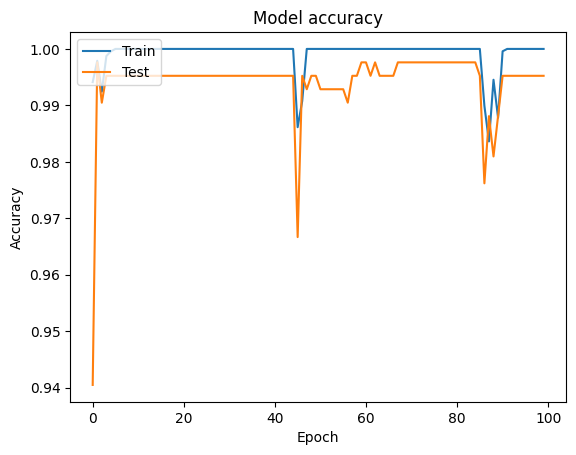

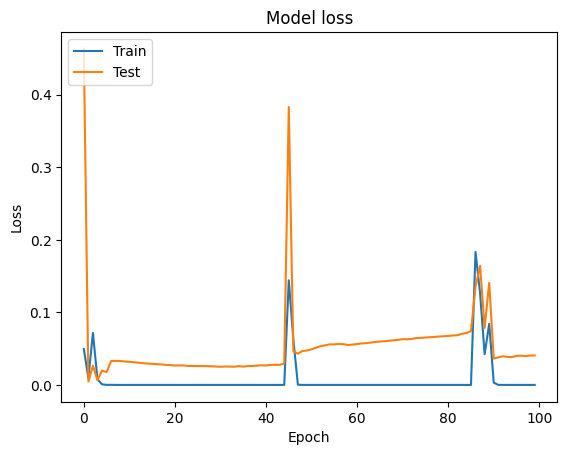

In [15]:

history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_test, y_test))


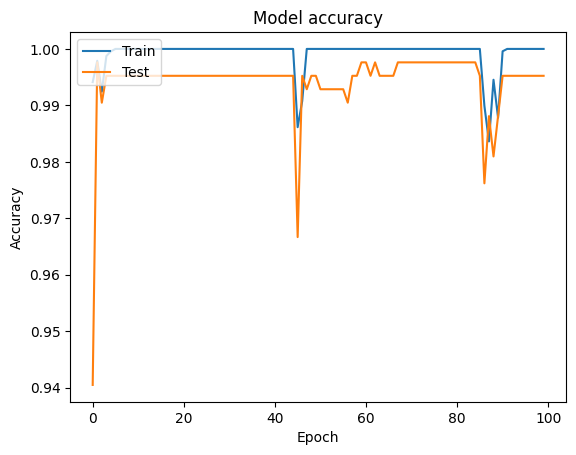

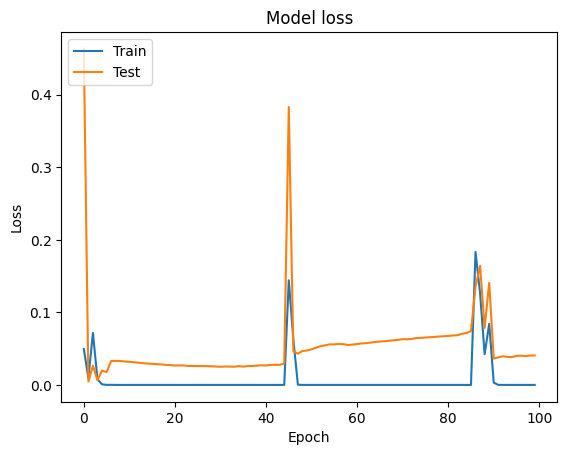

In [16]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**GRU Architecture**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GRUClassification(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_layers, num_classes, device):
        super().__init__()
        
        self.hidden_sz = hidden_sz
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.device = device
        
        self.gru = nn.GRU(input_sz, hidden_sz, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_sz, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_sz).to(self.device)
        
        x, _ = self.gru(x, h0)
        x = self.relu(x[:,-1,:])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.softmax(x)
        
        return output

In [ ]:
def train_validate(model, train_dataloader, validate_dataloader, loss_fn, optimiser, device, epochs):
    
    #creating empty list to stores losses and accuracy of train ,validation
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    
    # train the model
    for epoch in range(epochs):
        model.train()
        
        epoch_train_losses = []
        epoch_train_accs = []
        
        for i, (train_inputs, targets) in enumerate(train_dataloader):
            train_inputs, targets = train_inputs.to(device), targets.to(device)
            
            predictions = model(train_inputs)
            loss = loss_fn(predictions, targets)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            # Compute training accuracy
            train_acc = torch.sum(torch.argmax(predictions, dim=1) == targets).item() / len(targets)
            epoch_train_accs.append(train_acc)
            epoch_train_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        train_accs.append(np.mean(epoch_train_accs))
    
    
        # validate the model
        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            epoch_val_accs = []

            for valid_inputs, targets in validate_dataloader:
                valid_inputs = valid_inputs.to(device)
                targets = targets.to(device)

                outputs = model(valid_inputs)
                loss = loss_fn(outputs, targets)

                # Compute validation accuracy
                acc = torch.sum(torch.argmax(outputs, dim=1) == targets).item() / len(targets)
                epoch_val_accs.append(acc)
                epoch_val_losses.append(loss.item())

            val_acc = np.mean(epoch_val_accs)
            val_loss = np.mean(epoch_val_losses)
            val_accs.append(val_acc)
            val_losses.append(val_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
              .format(epoch + 1, epochs, train_losses[-1], train_accs[-1], val_loss, val_acc))
    
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
def test(model, dataloader, device):

    # Set the model to evaluation mode
    model.eval()

    # Create lists to store the predicted and ground truth labels
    predicted_labels = []
    true_labels = []

    # Iterate over the test data and make predictions
    with torch.no_grad():
        for test_data, targets in dataloader:
            test_data, targets = test_data.to(device), targets.to(device)
            
            outputs = model(test_data)
            loss = loss_fn(outputs, targets)

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Store the predicted and true labels
            predicted_labels.extend(list(predicted))
            true_labels.extend(list(targets))

    # Calculate the overall accuracy
    correct = 0
    total = 0
    for i in range(len(true_labels)):
        if predicted_labels[i] == true_labels[i]:
            correct += 1
        total += 1
    accuracy = correct / total
    print(f"Overall accuracy: {accuracy:.3f}")

In [ ]:
# BASE_DIR = '/kaggle/input/TESS Toronto emotional speech set data'

HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 7
EPOCHS = 100

LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'current deivce: {device}')

# Create an instance of the AudioDataset class
# audio_dataset = AudioDataset(BASE_DIR)

train_dataset = list(zip(x_train, y_train))
validation_dataset = list(zip(x_validation, y_validation))
test_dataset = list(zip(x_test, y_test))

# Create DataLoader instances for the datasets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

gru_model = GRUClassification(1, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, device).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses, train_accs, val_accs = train_validate(gru_model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS)

current deivce: cuda
Epoch [1/100], Train Loss: 1.6548, Train Acc: 0.5312, Val Loss: 1.5036, Val Acc: 0.6549
Epoch [2/100], Train Loss: 1.4498, Train Acc: 0.7196, Val Loss: 1.4147, Val Acc: 0.7572
Epoch [3/100], Train Loss: 1.3506, Train Acc: 0.8218, Val Loss: 1.3428, Val Acc: 0.8366
Epoch [4/100], Train Loss: 1.2988, Train Acc: 0.8694, Val Loss: 1.2867, Val Acc: 0.8757
Epoch [5/100], Train Loss: 1.2850, Train Acc: 0.8823, Val Loss: 1.2853, Val Acc: 0.8841
Epoch [6/100], Train Loss: 1.2580, Train Acc: 0.9091, Val Loss: 1.2440, Val Acc: 0.9225
Epoch [7/100], Train Loss: 1.2546, Train Acc: 0.9130, Val Loss: 1.2355, Val Acc: 0.9336
Epoch [8/100], Train Loss: 1.2316, Train Acc: 0.9364, Val Loss: 1.2081, Val Acc: 0.9577
Epoch [9/100], Train Loss: 1.2196, Train Acc: 0.9471, Val Loss: 1.2386, Val Acc: 0.9290
Epoch [10/100], Train Loss: 1.2238, Train Acc: 0.9440, Val Loss: 1.2060, Val Acc: 0.9596
Epoch [11/100], Train Loss: 1.2457, Train Acc: 0.9212, Val Loss: 1.2161, Val Acc: 0.9512
Epoch [12

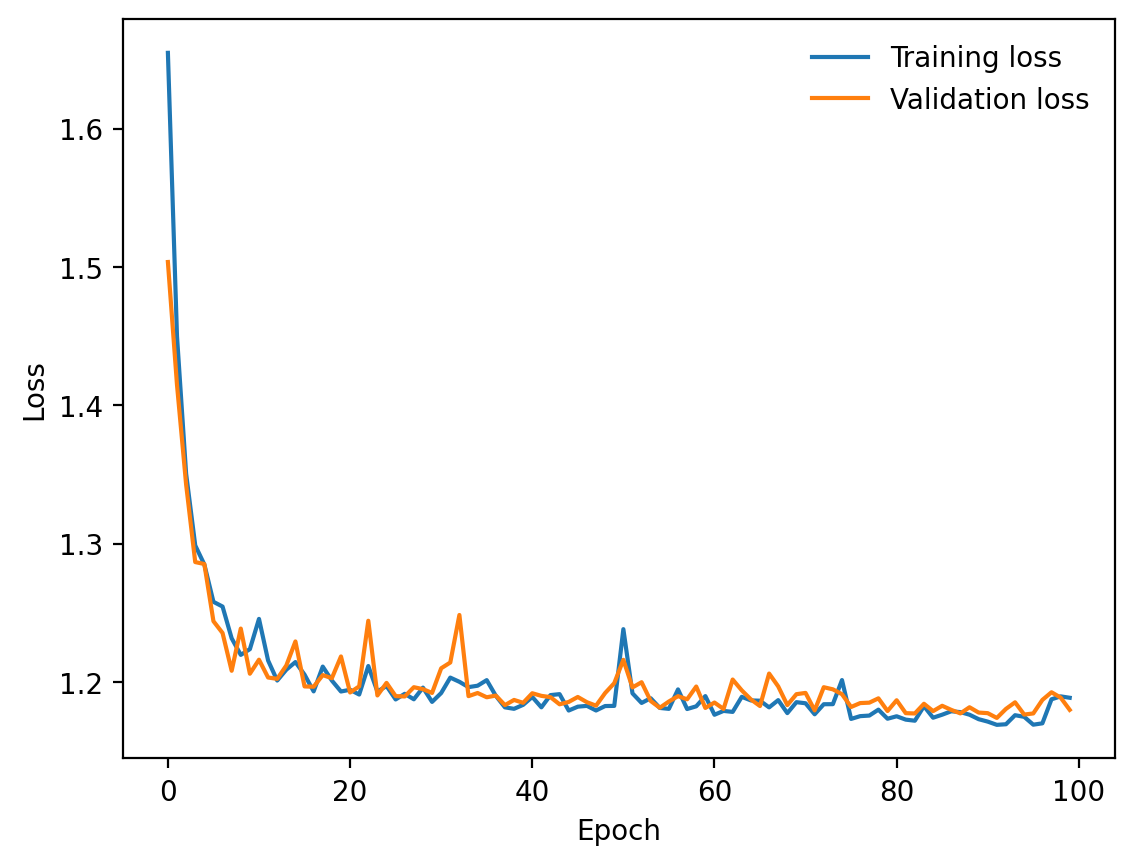

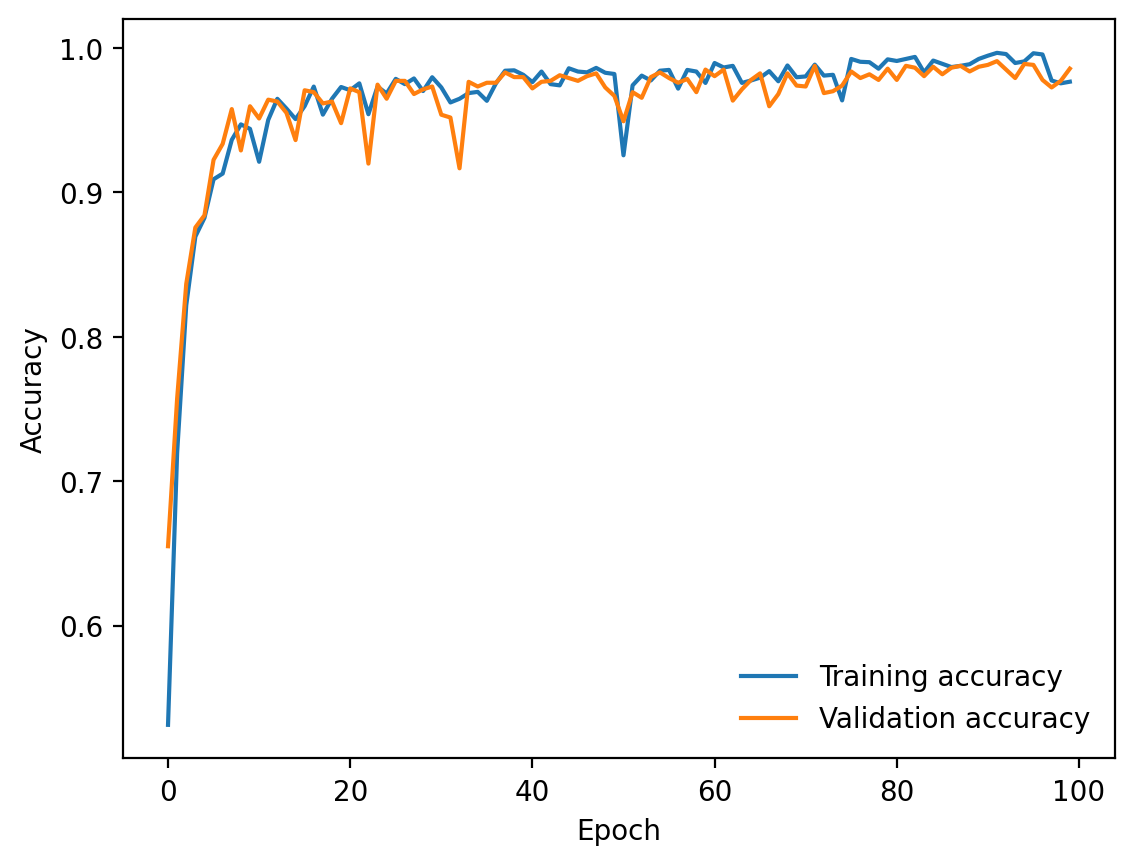

In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test(gru_model, test_dataloader, device)

Overall accuracy: 0.993
